In [12]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import shap

In [13]:
# Load datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Display the first few rows of the training data
print("Training Data:")
print(train_data.head())

# Display the first few rows of the test data
print("Test Data:")
print(test_data.head())

# Exploratory Data Analysis
print("Training Data Distribution:")
print(train_data['label'].value_counts())

Training Data:
  label                                            message
0   ham  Sun ah... Thk mayb can if dun have anythin on....
1   ham   None of that's happening til you get here though
2   ham             Thanx but my birthday is over already.
3   ham  Bognor it is! Should be splendid at this time ...
4  spam  For our project, catch the newest viral sensat...
Test Data:
                                             message
0  Your Number has won 365,000 pounds and two mob...
1             Okay but i thought you were the expert
2  We've noticed unusual sign-in activity on your...
3  if you aren't here in the next  &lt;#&gt;  hou...
4  Hei xxxx - Emme pystyneet toimittamaan paketti...
Training Data Distribution:
label
ham     4605
spam     712
Name: count, dtype: int64


In [14]:
# Data Preprocessing
# Label encoding for training labels
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])

# Define the vectorizer
vectorizer = TfidfVectorizer()

# Define classifiers
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(probability=True),  # SVM with probability=True for SHAP
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Prepare data for training
X_train = train_data['message']
y_train = train_data['label']
X_test = test_data['message']

--- Naive Bayes ---
Training Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4605
        spam       1.00      0.83      0.91       712

    accuracy                           0.98      5317
   macro avg       0.99      0.92      0.95      5317
weighted avg       0.98      0.98      0.98      5317



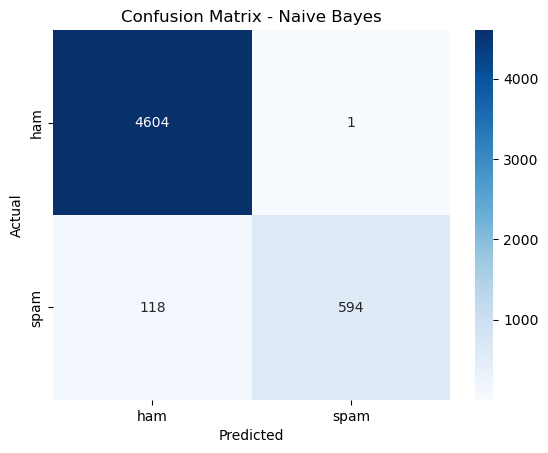

--- Logistic Regression ---
Training Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      4605
        spam       0.99      0.81      0.89       712

    accuracy                           0.97      5317
   macro avg       0.98      0.91      0.94      5317
weighted avg       0.97      0.97      0.97      5317



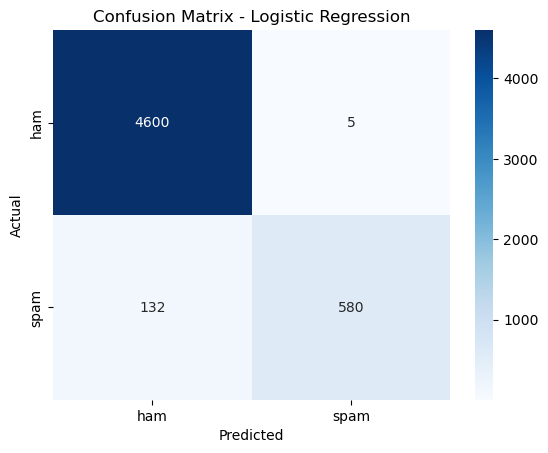

--- Support Vector Machine ---
Training Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4605
        spam       1.00      0.99      0.99       712

    accuracy                           1.00      5317
   macro avg       1.00      0.99      1.00      5317
weighted avg       1.00      1.00      1.00      5317



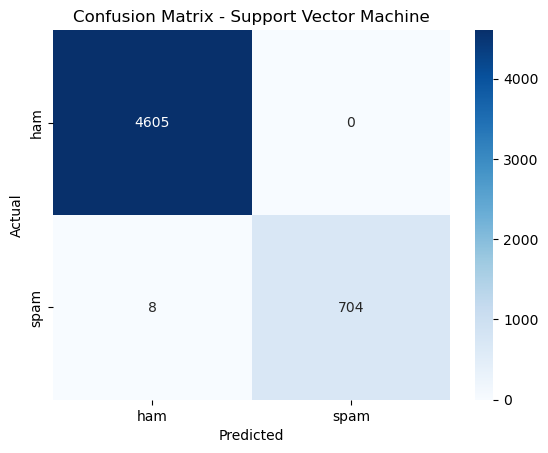

--- Random Forest ---
Training Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4605
        spam       1.00      1.00      1.00       712

    accuracy                           1.00      5317
   macro avg       1.00      1.00      1.00      5317
weighted avg       1.00      1.00      1.00      5317



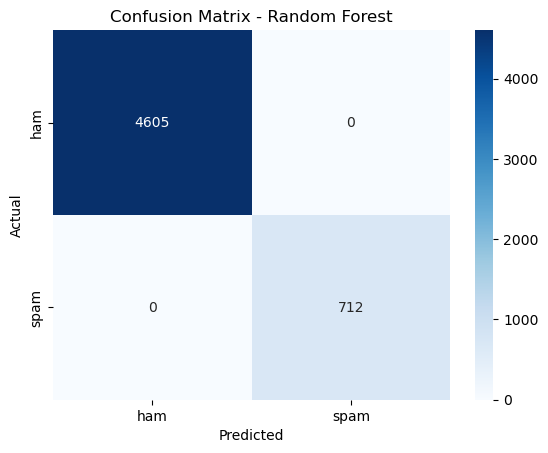

--- Gradient Boosting ---
Training Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4605
        spam       1.00      0.88      0.93       712

    accuracy                           0.98      5317
   macro avg       0.99      0.94      0.96      5317
weighted avg       0.98      0.98      0.98      5317



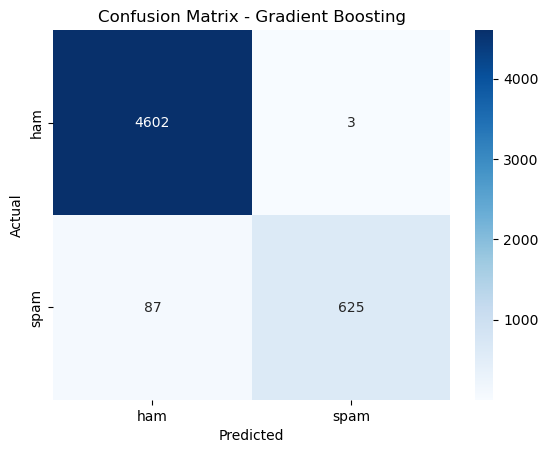

In [15]:
# Train and evaluate each classifier
results = {}

for name, clf in classifiers.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('clf', clf)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on training data (for evaluation purposes)
    y_train_pred = pipeline.predict(X_train)
    accuracy = accuracy_score(y_train, y_train_pred)
    
    # Predict on test data
    test_predictions = pipeline.predict(X_test)
    test_predictions_labels = label_encoder.inverse_transform(test_predictions)
    
    # Save predictions to a CSV file
    predictions_df = pd.DataFrame({
        'message': test_data['message'],
        'predicted_label': test_predictions_labels
    })
    
    # Evaluation on training data
    classification_rep = classification_report(y_train, y_train_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_train, y_train_pred, labels=label_encoder.transform(label_encoder.classes_))
    
    # Save results
    results[name] = {
        'accuracy': accuracy,
        'classification_report': classification_rep,
        'confusion_matrix': cm
    }

# Print results
for name, result in results.items():
    print(f"--- {name} ---")
    print(f"Training Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result['classification_report'])
    
    # Plot confusion matrix
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

--- Voting Classifier ---
Training Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      4605
        spam       1.00      0.98      0.99       712

    accuracy                           1.00      5317
   macro avg       1.00      0.99      0.99      5317
weighted avg       1.00      1.00      1.00      5317



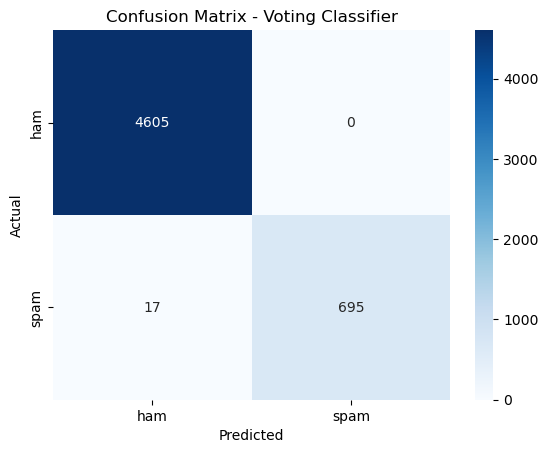

In [16]:
# Ensemble Classifier: Voting Classifier
# Create pipelines for each classifier
pipelines = [(name, Pipeline([
    ('tfidf', vectorizer),
    ('clf', clf)
])) for name, clf in classifiers.items()]

# Create a VotingClassifier
voting_clf = VotingClassifier(estimators=pipelines, voting='soft')

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Predict on test data
test_predictions = voting_clf.predict(X_test)
test_predictions_labels = label_encoder.inverse_transform(test_predictions)

# Save ensemble predictions to a CSV file
ensemble_predictions_df = pd.DataFrame({
    'message': test_data['message'],
    'predicted_label': test_predictions_labels
})
ensemble_predictions_df.to_csv('test_labels.csv', index=False)

# Evaluate the ensemble model
y_train_pred = voting_clf.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
classification_rep = classification_report(y_train, y_train_pred, target_names=label_encoder.classes_)
cm = confusion_matrix(y_train, y_train_pred, labels=label_encoder.transform(label_encoder.classes_))

print("--- Voting Classifier ---")
print(f"Training Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()